In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import math
import os
import pickle
%matplotlib inline

In [2]:
# Function to display a numpy array of images and their labels
def displayImg(images, labels, nImg, rows, cols, formatType, hFigure):

    plt.figure(figsize=(15, hFigure))        
    plt.axis('on')
    for i in range(nImg):
        plt.subplot(rows, cols, i+1)           
        plt.title(str(labels[i]))
        if formatType == 'BGR': plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        elif formatType == 'HLS': plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_HLS2RGB))
        elif formatType == 'GRAY': plt.imshow(images[i], cmap='gray')
        elif formatType == 'HIST': plt.plot(images[i])
            
        else: plt.imshow(images[i])
    plt.show()

In [3]:
objPoints=[]
imgPoints=[]
labelOk = []
imgOk= []
imgError=[]
labelError=[]
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #Generates x,y coordinates

images = glob.glob('camera_cal/calibration*.jpg')

for imgName in images:
    # Read every image
    img = cv2.imread(imgName)        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert Image to Gray Scale

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objp)
        # draw corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        imgOk.append(img[0:720,0:1280])
        labelOk.append(imgName)
    else:
        imgError.append(img)
        labelError.append(imgName)
        
print('Result:',len(imgError),'out of',len(images),'were not found corners')

Result: 3 out of 20 were not found corners


In [4]:
#Converting to numpy vectors the list of images and labels
imgOk = np.array(imgOk)
labelOk = np.array(labelOk)
print(imgOk.shape, labelOk.shape)

imgError = np.array(imgError)
labelError = np.array(labelError)
print(imgError.shape, labelError.shape)

(17, 720, 1280, 3) (17,)
(3, 720, 1280, 3) (3,)


## Images with Corners Detected 

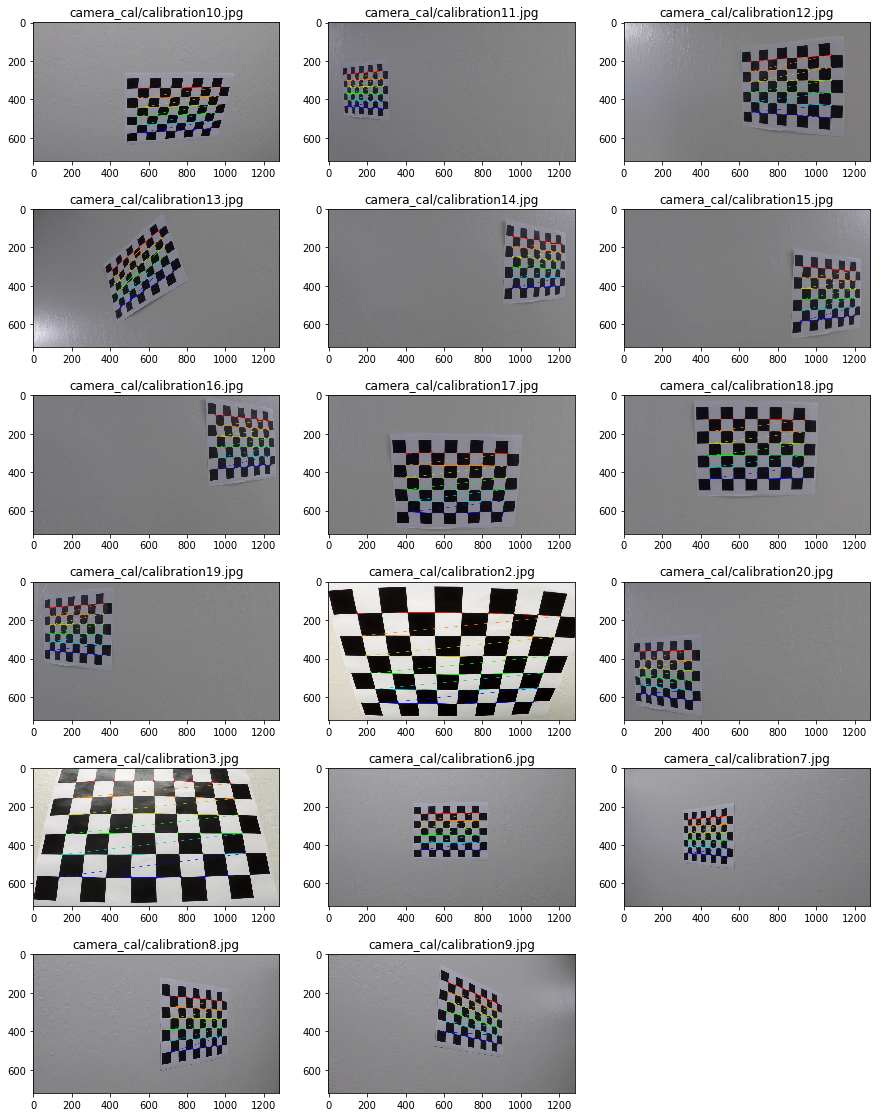

In [5]:
displayImg(imgOk[0:17,:,:], labelOk[0:17], nImg=17, rows=6, cols=3, formatType='BGR', hFigure=20)

## Images that Corners were not Detected

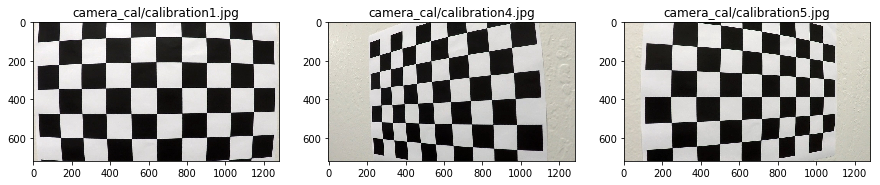

In [6]:
displayImg(imgError[0:3,:,:], labelError[0:3], nImg=3, rows=1, cols=3, formatType='BGR', hFigure=10)

## Camera Calibration

In [7]:
# Calibrate the camera using the chess points founded
imgTest = cv2.imread('camera_cal/calibration1.jpg')

imgSize = (imgTest.shape[1], imgTest.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imgSize, None,None)
print('Camera Calibrated...')

Camera Calibrated...


In [8]:
# Saving the Camera Parameters
mydict = {'mtx': mtx, 'dist': dist}
output = open('calibration_params.p', 'wb')
pickle.dump(mydict, output)
output.close()

In [11]:
print(mydict)

{'mtx': array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
       [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]), 'dist': array([[-0.24688507, -0.02373155, -0.00109831,  0.00035107, -0.00259867]])}


## Sample Undistortioned Image

In [8]:
# returns an image undistorted
def imgUndistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

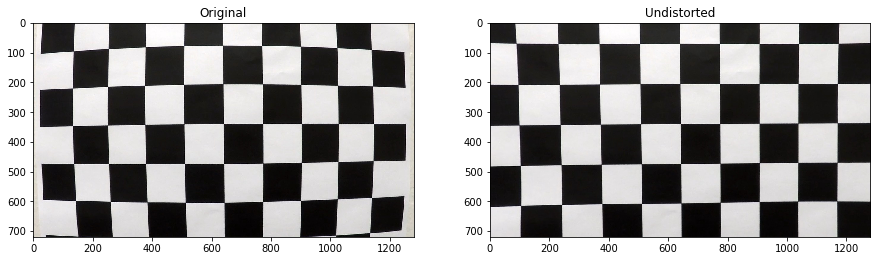

In [9]:
imgUndist = imgUndistort(imgTest, mtx, dist)
images = []
images.append(imgTest)
images.append(imgUndist)

images = np.array(images)
ulabels = np.array(['Original','Undistorted'])
displayImg(images, ulabels, nImg=2, rows=1, cols=2, formatType='BGR', hFigure=5)

## Loading, Cropping and Undistorting Images for Testing

In [10]:
## Cropping Image to eliminate the front part of the car
def cropImg(img):    
    h,w,ch = img.shape
    cropImg = img[0:h-52,0:w,:]
    return cropImg

In [11]:
# Reading Test Images
inDirectory = "test_images/"

# Reading input list of images
testImages=[] 
testLabels = []
imgPath= os.listdir(inDirectory)
# Loop to read all the images
for cnt in range(0,len(imgPath)):    
    # Reading the image from input folder, in RGB Format    
    testImages.append(imgUndistort(cropImg(mpimg.imread(inDirectory + imgPath[cnt])), mtx, dist))
    testLabels.append(imgPath[cnt])
testImages = np.array(testImages) 
testLabels = np.array(testLabels)

## Testing Images Undistorted

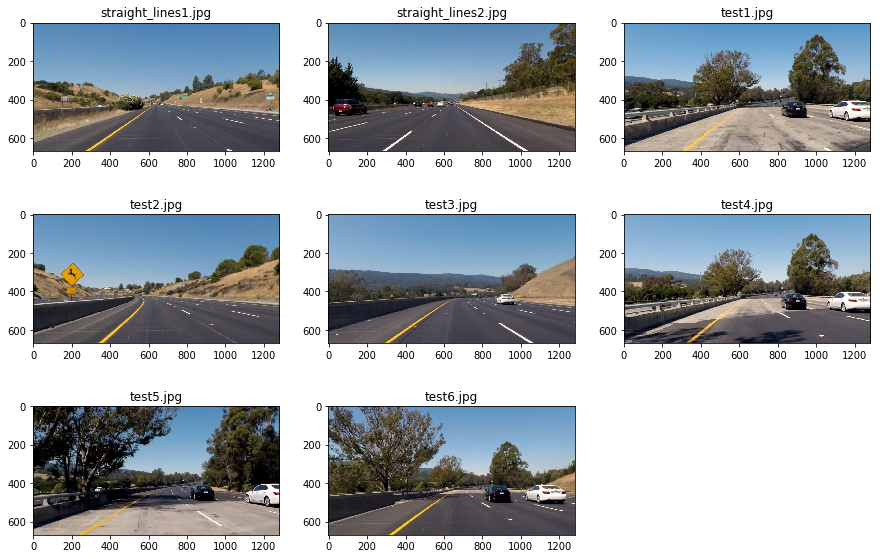

In [12]:
n = testImages.shape[0]
displayImg(testImages, testLabels, nImg=n, rows=3, cols=3, formatType='', hFigure=10)

In [13]:
# cv2.imwrite(inDirectory + 'undistTest6.jpg', testImages[7],[cv2.IMWRITE_JPEG_QUALITY, 90])

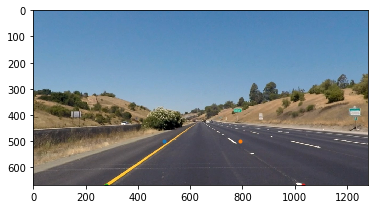

In [14]:
plt.imshow(testImages[0])
plt.plot(500,500,'.') #Top Left
plt.plot(790,500,'.') #Top Right
plt.plot(280,667,'.') #Bottom Left
plt.plot(1030,667,'.') #Bottom Right

## Perspective Transformation

In [15]:
# Main image transformation routine to get a warped image

def imgPerspective(img, src, dst, typeP='pnorm'):
    (h , w, c) = img.shape
    if typeP == 'pnorm':
        M = cv2.getPerspectiveTransform(src, dst)
    elif typeP == 'pinv':
        M = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR) 

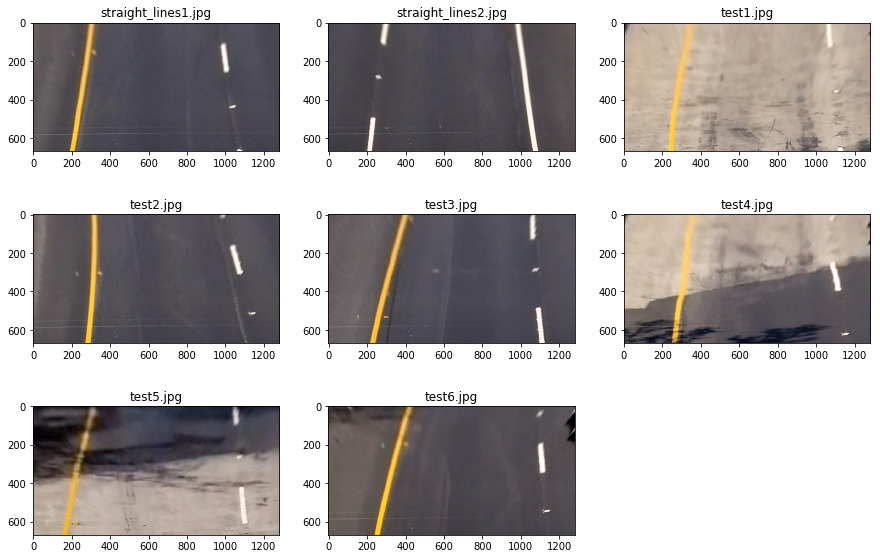

In [16]:
(h , w, c) = testImages[0].shape
offset = 200
# Define the point for the Perspective Transformation
# topL, topR, botL, botR
src = np.float32([[500, 500], [790, 500], [280, 667], [1030, 667]])
# src = np.float32([[569, 460], [728, 460], [280, 667], [1030, 667]])
dst = np.float32([[0+offset,0+offset], [w-offset, 0+offset], [0+offset, h],[w-offset, h]])

imgTransformed = []
for i in range(n):    
    imgTransformed.append(imgPerspective(testImages[i],src,dst,typeP='pnorm'))
    cv2.imwrite('trans_images/test' + str(i) + '.jpg',imgTransformed[i],[cv2.IMWRITE_JPEG_QUALITY, 90])

displayImg(imgTransformed, testLabels, nImg=n, rows=3, cols=3, formatType='', hFigure=10)

## Filtering Lane Lines and Binary Transformation

In [17]:
# Selection of Yellow and White Pixels
def select_yellow(image):    
    lower = np.array([165,153,74])
    upper = np.array([255,214, 145])
    mask = cv2.inRange(image, lower, upper)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= mask)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    return res

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= mask)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    return res

In [18]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
def claheContrast(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

In [19]:
def binTransformation(img, cthresh=(160, 170)):    
    
    whiteLine = select_white(img)
    yellowLine = select_yellow(img)    
    cbinary = np.zeros_like(whiteLine)
    cbinary[(whiteLine > cthresh[0]) | (yellowLine > cthresh[1])] = 1  
    
    return cbinary

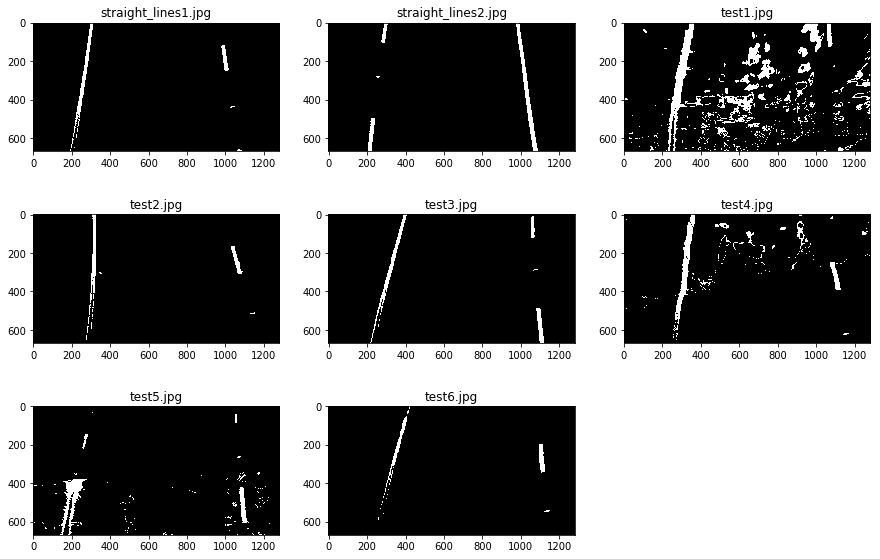

In [20]:
images = []
for i in range(n):
    images.append(binTransformation(imgTransformed[i], cthresh=(160, 150)))

displayImg(images, testLabels, nImg=n, rows=3, cols=3, formatType='GRAY', hFigure=10)

In [21]:
histogram=[]
for i in range(n):
    tmp = images[i]
    histogram.append(np.sum(tmp[tmp.shape[0]//2:,:], axis=0))

# displayImg(histogram, testLabels, nImg=n, rows=3, cols=3, formatType='HIST', hFigure=10)

In [66]:
def polynomialfit(binary_warped, hist):
    global flagStart, text1, frames
    global left_fit, right_fit, last_leftx_mean, last_rightx_mean
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    text=''
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    meter_lane_midpoint = (rightx_base + leftx_base) / 2 * (3.7/700)
    meter_image_midpoint = midpoint * (3.7/700)
    
    #Calculates the Center Distance
    center_distance = abs(meter_image_midpoint-meter_lane_midpoint)
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    if flagStart == True:
        flagStart = False
#         print(' Windows Flag=False')
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        
        if (len(leftx)< minpix or len(lefty)< minpix or len(rightx)<minpix or len(righty)<minpix):
            flagStart = True    
        else:
            
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        

    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
       
        if (len(leftx)< minpix or len(lefty)< minpix or len(rightx)<minpix or len(righty)<minpix):
            flagStart = True
            
        else:        
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
        
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            window_img = np.zeros_like(out_img)

            # Draw the lane onto the warped blank image

            xyLeft = np.dstack((left_fitx,ploty))
            xyRight = np.dstack((right_fitx,ploty))
            xyrightFlipped = np.fliplr(xyRight)        
            xyTotal = np.hstack((xyLeft, xyrightFlipped))

            # Calculating the Radius of Curvature
            y_eval = np.max(ploty)
            if frames >= 10:
                frames = 0
                # Define conversions in x and y from pixels space to meters
                ym_per_pix = 30/720 # meters per pixel in y dimension
                xm_per_pix = 3.7/700 # meters per pixel in x dimension

                # Fit new polynomials to x,y in world space
                left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
                right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix,2)
                
                # Calculate the new radii of curvature
                left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
                right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
                text1 = 'Left curvature: ' + str('{:04.2f}'.format(left_curverad)) + ' m ' + 'Right curvature: ' + str('{:04.2f}'.format(right_curverad)) + ' m' + ' Center Dist: ' + str('{:02.2f}'.format(center_distance))
            frames += 1
            out_img = cv2.fillPoly(window_img, np.int_([xyTotal]), (0,255, 0))
    
    return out_img

In [60]:
# Return the Histogram of the image bottom half part
def histCalculation(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)
    
def pipeline(img):
    global text1
    (h , w, c) = img.shape
    
    # Define the point for the Perspective Inverse Transformation
    # topL, topR, botL, botR
    offset = 200
    src = np.float32([[500, 500], [790, 500], [280, 667], [1030, 667]])
#     src = np.float32([[569, 460], [728, 460], [280, 667], [1030, 667]])
    dst = np.float32([[0+offset,0+offset], [w-offset, 0+offset], [0+offset, h],[w-offset, h]])

    img = imgUndistort(img, mtx, dist)
    imgP = imgPerspective(img, src, dst, typeP='pnorm')
    
    imgB = binTransformation(imgP, cthresh=(160, 157))
#     imgB = np.dstack((imgB, imgB, imgB))*255
#     imgOut = imgB
    hist = histCalculation(imgB)
    imgOut = polynomialfit(imgB, hist)
    imgOut = imgPerspective(imgOut, src, dst, typeP='pinv')
    imgOut = cv2.putText(imgOut, text1,(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
    imgOut = cv2.addWeighted(img, 1, imgOut, 0.3, 0)

#     cv2.imwrite('pers.png',cv2.cvtColor(imgOut, cv2.COLOR_BGR2RGB))
    return imgOut

(668, 1280, 3)


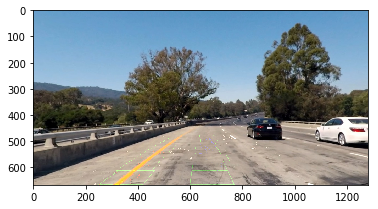

In [61]:
flagStart = True
left_fit =''
right_fit = ''
frames = 0
text1 =''
img = testImages[2]
out_img = pipeline(img)
plt.imshow(out_img)
print(out_img.shape)
# cv2.imwrite('windows.png',out_img)

## Obtaining Images from the Video

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Project Video

In [67]:
flagStart = True
left_fit =''
right_fit = ''
frames = 0
text1 =''

inputPath = 'videos/input/project_video.mp4'
outputPath = 'videos/output/project_video.mp4'
# clip1 = VideoFileClip(inputPath).subclip(0,10)
clip1 = VideoFileClip(inputPath)

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(outputPath, audio=False)


[MoviePy] >>>> Building video videos/output/project_video.mp4
[MoviePy] Writing video videos/output/project_video.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  4.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/output/project_video.mp4 

CPU times: user 15min 30s, sys: 23.6 s, total: 15min 53s
Wall time: 5min 43s
